# 18. Analizando nuestro primer modelo

## Importamos paquetes necesarios

In [1]:
import pandas as pd
import numpy as np
import pydotplus

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

from skopt import gp_minimize
from skopt.space import Categorical, Dimension, Integer, Real  # noqa

from IPython.display import Image  

import graphviz_tools as agt
import mlflow_utils as a_mlflow_u
import tree_utils as atu

## Cargamos nuestros dataset

In [43]:
file_cervezas_unicas_resumen_valores_con_clase_training = 'dataset/cervezas_unicas_resumen_valores_con_clase_train.csv'
file_cervezas_unicas_resumen_valores_con_clase_testing = 'dataset/cervezas_unicas_resumen_valores_con_clase_test.csv'

campos = ['beer_abv', 'review_aroma', 'review_appearance', 'review_overall', 'review_palate', 'es_popular']

df_training_validacion = pd.read_csv(file_cervezas_unicas_resumen_valores_con_clase_training)
df_testing = pd.read_csv(file_cervezas_unicas_resumen_valores_con_clase_testing)
df_info = df_testing.copy()

df_training_validacion = df_training_validacion.loc[:, campos]
df_testing = df_testing.loc[:, campos]

df_training_validacion.head()

,beer_abv,review_aroma,review_appearance,review_overall,review_palate,es_popular
0,6.0,3.564000,3.736000,3.776000,3.620000,NO
1,4.5,2.608108,3.351351,2.945946,3.054054,NO
2,4.4,3.727273,3.727273,3.545455,3.545455,NO
3,7.5,3.750000,3.500000,3.750000,4.000000,NO
4,7.8,2.500000,3.500000,3.500000,3.500000,NO


In [3]:
random_state = 1
test_size = 0.3

atributos = ['beer_abv', 'review_aroma', 'review_appearance', 'review_overall', 'review_palate']
clase = ['es_popular']

Y_df_training_validacion = df_training_validacion.loc[:, clase]
df_training_validacion = df_training_validacion.loc[:, atributos]

### Tambien abrimos en X e Y el dataset de testing

In [4]:
X_testing = df_testing.loc[:, atributos]
Y_testing = df_testing.loc[:, clase]

### Utilizamos estos parámetros para crear un nuevo modelo

In [5]:
umbral_de_corte = 0.9686563912780112
max_depth = 15
min_samples_split =  0.005344619941737348
max_features =  0.5783780242657676

#criterion='entropy'
criterion='gini'
#criterion='log_loss'

clf = DecisionTreeClassifier(
            criterion = criterion,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            max_features=max_features,
            random_state=1
        )
_ = clf.fit(df_training_validacion, Y_df_training_validacion)


### Probamos los nuevos parámetros en testing

In [6]:
y_testing_pred = clf.predict_proba(X_testing)

df_y_testing_pred_proba = pd.DataFrame(y_testing_pred, columns = ['NO_prob', 'SI_prob'])
y_testing_pred = atu.evaluar_corte(df_y_testing_pred_proba['NO_prob'].values, umbral_de_corte, 'SI', 'NO')

metricas = atu.calcular_metricas(
    y_true = Y_testing['es_popular'].values, 
    y_pred = y_testing_pred, 
    labels=['NO', 'SI']
)

parametros = {
    'max_depth': max_depth,
    'umbral_corte': umbral_de_corte, 
    'min_samples_split': min_samples_split,
    'max_features': max_features
}
    
[metricas, parametros]

[{'true negatives': 10426,
  'true positives': 660,
  'false positives': 3540,
  'false negatives': 78,
  'accuracy': 0.7539,
  'recall': 0.8943,
  'precision': 0.1571,
  'specificity': 0.7465,
  'tasa falso positivo': 0.2535,
  'tasa falso negativo': 0.0056,
  'f1': 0.2673,
  'metrica negocio': 131.39281828073993,
  'metrica optima negocio': 200.76169749727964},
 {'max_depth': 15,
  'umbral_corte': 0.9686563912780112,
  'min_samples_split': 0.005344619941737348,
  'max_features': 0.5783780242657676}]

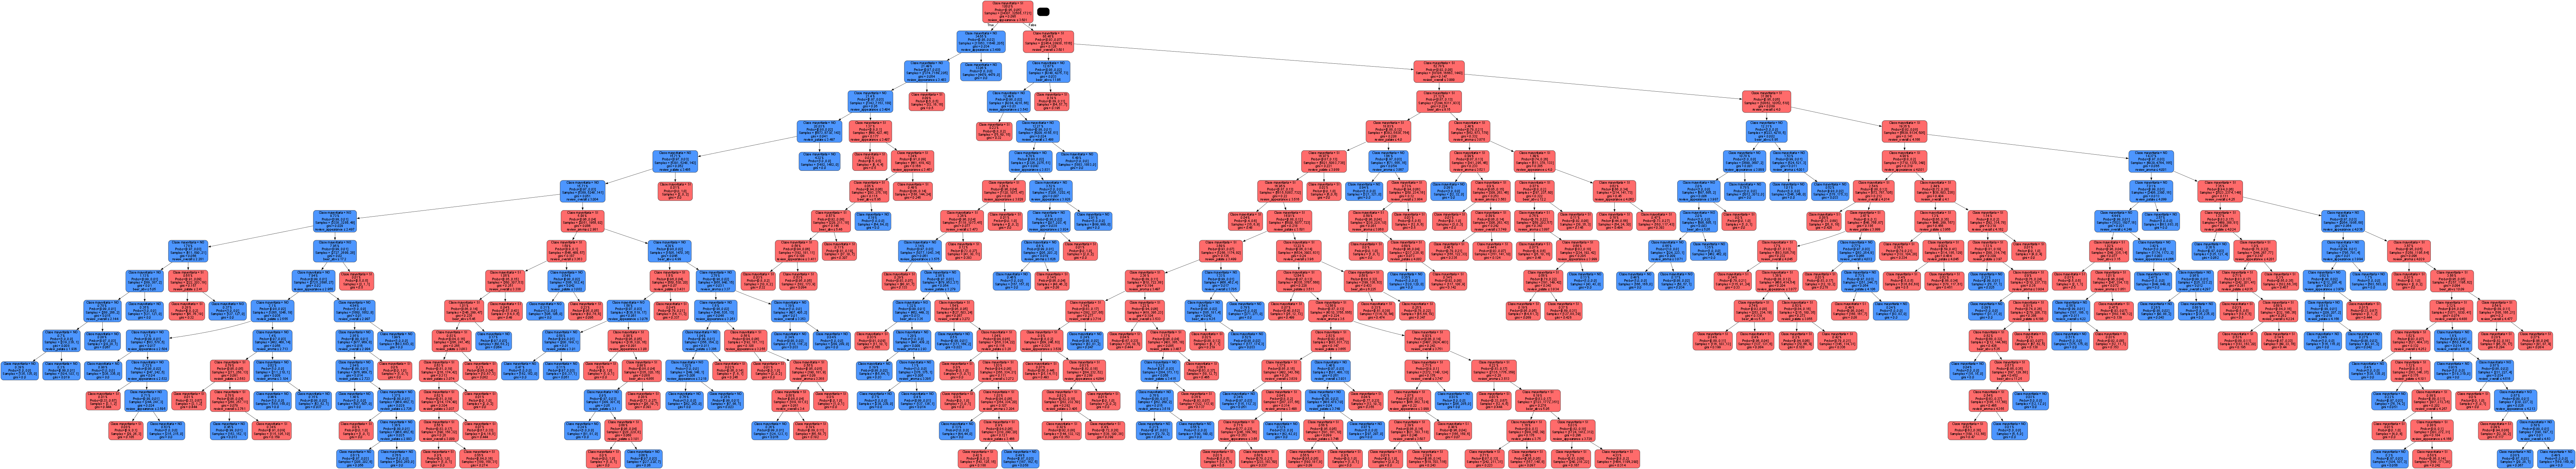

In [7]:
dot_data_value = agt.crear_arbol(clf, negative_class = 'NO', positive_class = 'SI', umbral = umbral_de_corte)

graph = pydotplus.graph_from_dot_data(dot_data_value)  
graph.set_size('"75,75"')

Image(graph.create_png())

In [8]:
from sklearn.tree._tree import TREE_LEAF


def get_node_class (inner_tree, index, umbral, negative_class, positive_class):
    class_a = inner_tree.value[index][0][0]
    class_b = inner_tree.value[index][0][1]
    prob_a = class_a / (class_a + class_b)
    prob_b = 1 - prob_a
    if(prob_a > umbral):
        return negative_class
    else:
        return positive_class
    
def get_node_classes (inner_tree, index, umbral, negative_class, positive_class):
    result = []
    
    if(inner_tree.children_left[index] == TREE_LEAF):
        result = [get_node_class(inner_tree, index, umbral, negative_class, positive_class)]
    else:
        result = (
            get_node_classes(inner_tree, inner_tree.children_left[index], umbral, negative_class, positive_class) +
            get_node_classes(inner_tree, inner_tree.children_right[index], umbral, negative_class, positive_class)
        )
        
    return result



def prune_index(inner_tree, index, umbral):
    clases_hojas = get_node_classes(inner_tree, index, umbral, 'NO', 'SI')
    #print(index, clases_hojas)
    res = np.array(clases_hojas) 
    unique_res = np.unique(res)
    if(len(unique_res) == 1):
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        
        #right_class = get_right_node_class(inner_tree, index, umbral, 'NO', 'SI')
        #if(left_class == right_class):
        #    inner_tree.children_left[index] = TREE_LEAF
        #    inner_tree.children_right[index] = TREE_LEAF
    
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], umbral)
        prune_index(inner_tree, inner_tree.children_right[index], umbral)



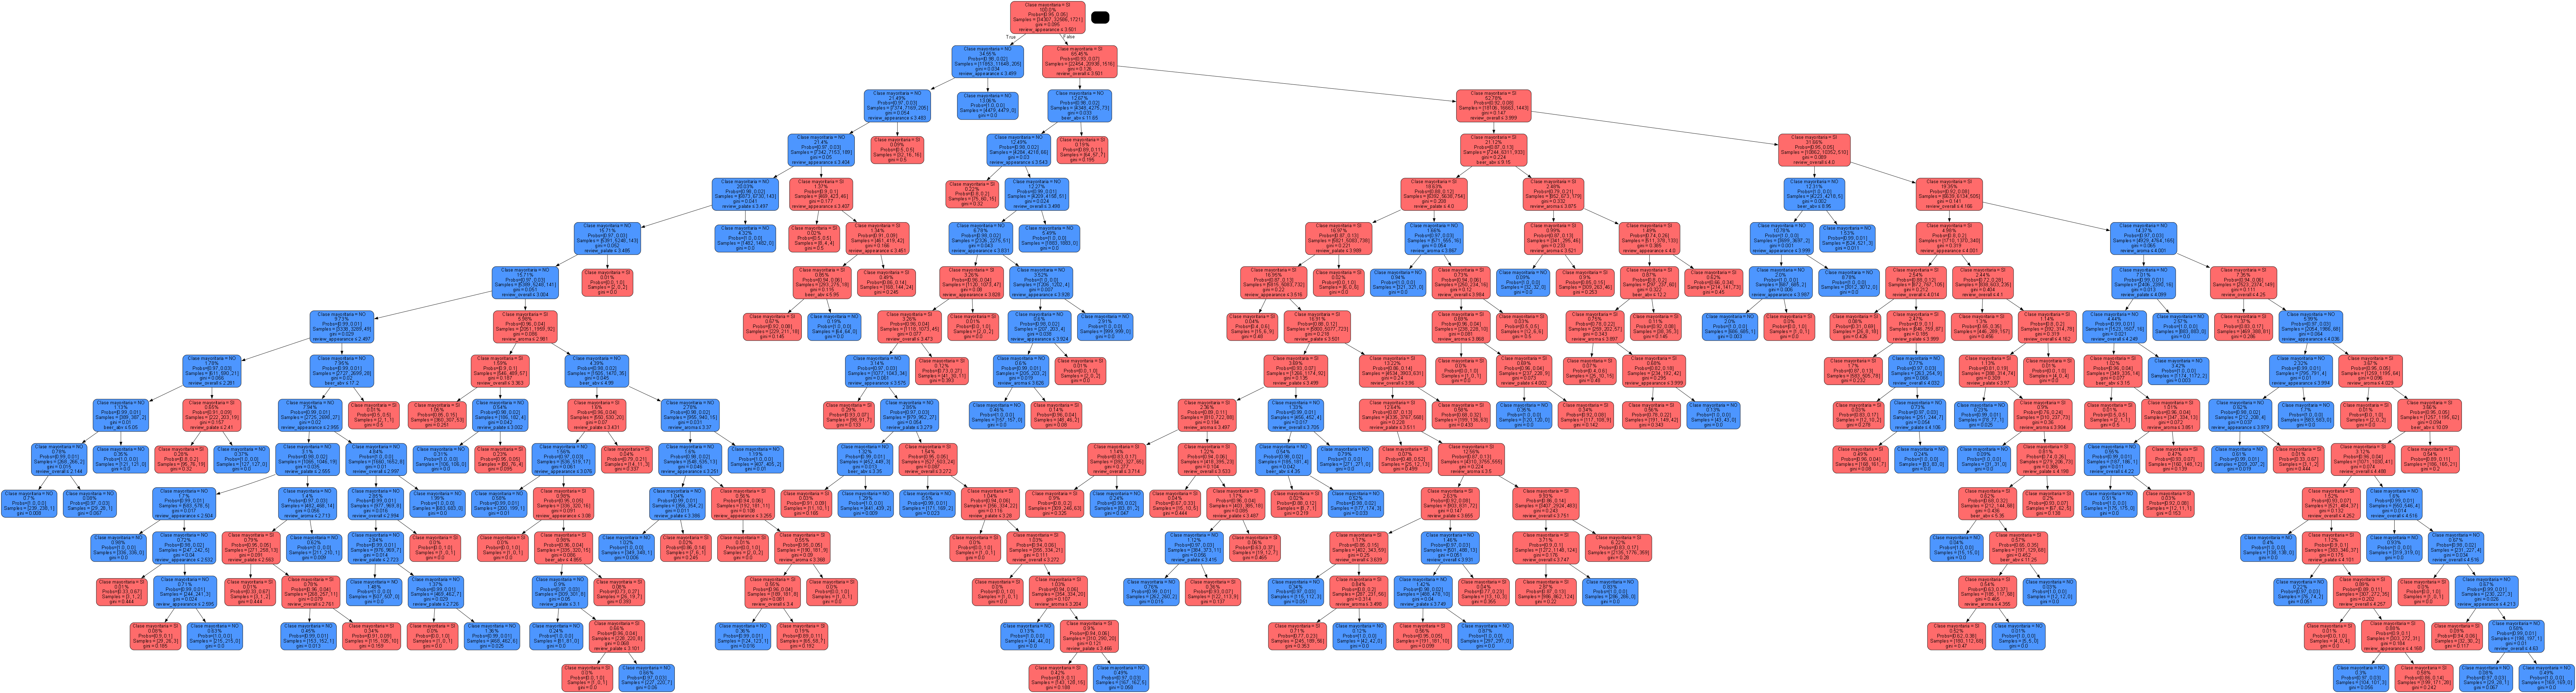

In [9]:
import importlib
importlib.reload(agt)

prune_index(clf.tree_, 0, umbral_de_corte)

dot_data_value = agt.crear_arbol(clf, negative_class = 'NO', positive_class = 'SI', umbral = umbral_de_corte)

graph = pydotplus.graph_from_dot_data(dot_data_value)  
graph.set_size('"75,75"')

Image(graph.create_png())

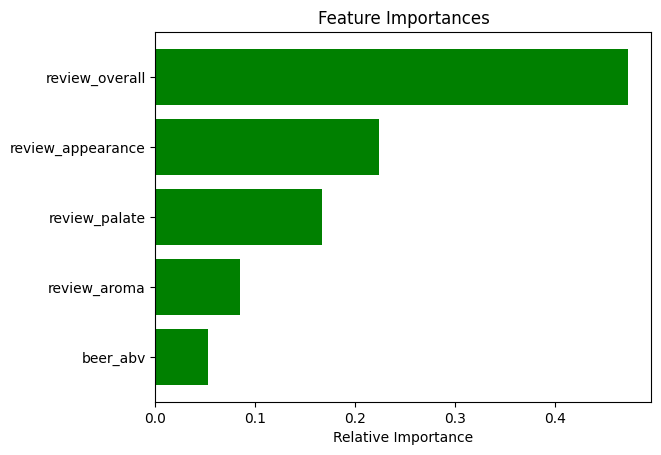

In [10]:
importances = clf.feature_importances_
indices = np.argsort(importances)
features = campos
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Usamos SHAP values para explicar las importancias

In [12]:
import shap

In [13]:
umbral_de_corte

0.9686563912780112

In [14]:
y_testing_pred = clf.predict_proba(X_testing)
df_y_testing_pred_proba = pd.DataFrame(y_testing_pred, columns = ['NO_prob', 'SI_prob'])
y_testing_pred = atu.evaluar_corte(df_y_testing_pred_proba['NO_prob'].values, umbral_de_corte, 'SI', 'NO')

In [15]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_testing)

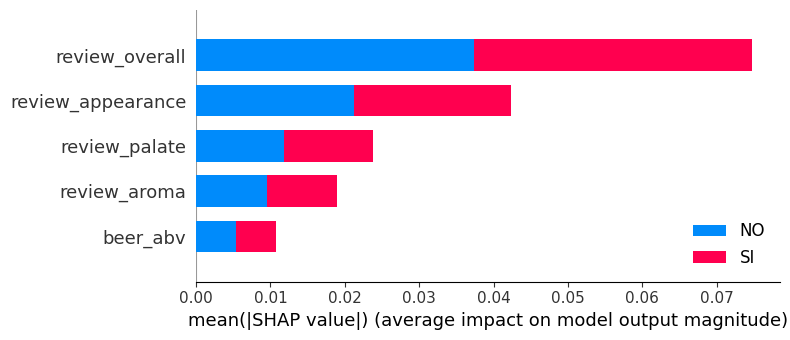

In [16]:
#Aportes a la clase NO
shap.summary_plot(shap_values, X_testing.values, feature_names = atributos, class_names= ['NO','SI'])

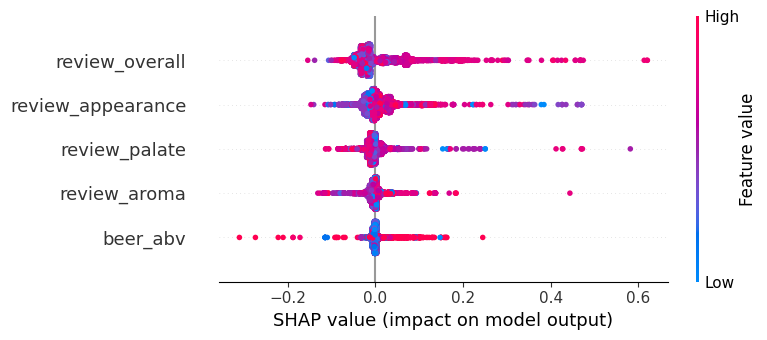

In [18]:
#Aportes a la clase SI
shap.summary_plot(shap_values[1], X_testing.values, feature_names = atributos)

In [19]:
shap_df = pd.DataFrame(data = shap_values[1])
shap_df.columns = ['shap_' + sub for sub in atributos]
shap_df = pd.concat([shap_df, X_testing, df_y_testing_pred_proba, Y_testing], axis=1)
shap_df['es_popular_prediccion'] = y_testing_pred
shap_df

,shap_beer_abv,shap_review_aroma,shap_review_appearance,shap_review_overall,shap_review_palate,beer_abv,review_aroma,review_appearance,review_overall,review_palate,NO_prob,SI_prob,es_popular,es_popular_prediccion
0,0.002403,-0.021396,-0.001192,-0.000964,0.001821,3.9,3.500000,3.250000,3.250000,3.250000,0.969163,0.030837,NO,NO
1,-0.007442,0.009230,0.014994,-0.024028,-0.016603,6.2,4.300000,4.166667,4.300000,4.000000,0.973684,0.026316,NO,NO
2,-0.001257,-0.001425,-0.004089,-0.044066,0.000673,8.2,2.500000,4.000000,2.500000,3.000000,1.000000,0.000000,NO,NO
3,-0.004504,-0.001358,0.007270,-0.036226,-0.015346,5.1,4.000000,4.500000,4.000000,3.500000,1.000000,0.000000,NO,NO
4,-0.002745,-0.005564,0.003518,-0.029860,-0.013810,5.3,3.750000,3.750000,4.250000,3.500000,0.998296,0.001704,NO,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14699,-0.001916,-0.006499,-0.004672,-0.023853,-0.013225,7.6,3.000000,4.000000,3.000000,3.500000,1.000000,0.000000,NO,NO
14700,-0.002405,-0.000950,-0.001885,-0.029191,-0.014030,5.0,4.000000,4.000000,4.500000,4.000000,0.998296,0.001704,NO,NO
14701,-0.002503,0.000823,-0.002913,-0.031014,-0.014558,6.6,4.500000,4.000000,4.500000,4.000000,1.000000,0.000000,NO,NO
14702,-0.001376,0.002131,-0.020576,-0.028972,-0.001372,5.0,2.500000,3.000000,2.500000,2.000000,1.000000,0.000000,NO,NO


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


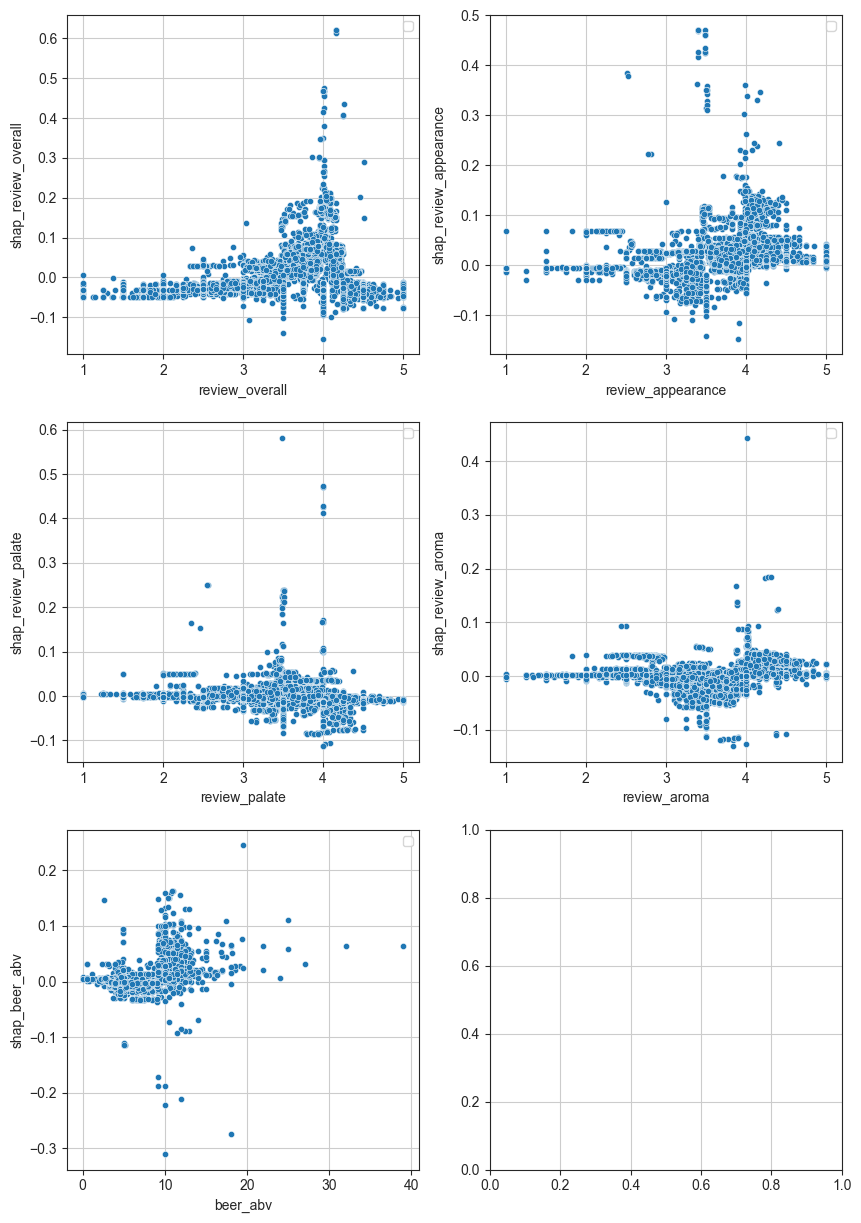

In [52]:
sns.set_style("ticks",{'axes.grid' : True})
fig, ([[ax1, ax2], [ax3, ax4], [ax5, ax6]]) = plt.subplots(3, 2, figsize=(10, 15))

field = 'review_overall'
g1 = sns.scatterplot(data=shap_df, x=field, y='shap_'+field, s=20, ax=ax1)
g1.legend(fontsize=9)

field = 'review_appearance'
g3 = sns.scatterplot(data=shap_df, x=field, y='shap_'+field, s=20, ax=ax2)
g3.legend(fontsize=9)

field = 'review_palate'
g2 = sns.scatterplot(data=shap_df, x=field, y='shap_'+field, s=20, ax=ax3)
g2.legend(fontsize=9)

field = 'review_aroma'
g1 = sns.scatterplot(data=shap_df, x=field, y='shap_'+field, s=20, ax=ax4)
g1.legend(fontsize=9)

field = 'beer_abv'
g4 = sns.scatterplot(data=shap_df, x=field, y='shap_'+field, s=20, ax=ax5)
g4.legend(fontsize=9)


plt.show()

### Casos de cervezas NO populares

##############################################################################
beer_beerid                              61881
beer_name              Old Crow's Beak Rye Ale
brewery_id                                 487
brewery_name             Tampa Bay Brewing Co.
beer_style                            Rye Beer
beer_abv                                   5.2
review_overall                             3.0
review_aroma                               3.0
review_appearance                          3.0
review_palate                              3.5
review_taste                               4.0
cantidad_revisiones                          1
revision_primera                    2010-09-16
revision_ultima                     2010-09-16
es_popular                                  NO
Name: 826, dtype: object
##############################################################################
shap_beer_abv            -0.001515
shap_review_aroma        -0.005548
shap_review_appearance   -0.020402
shap_re

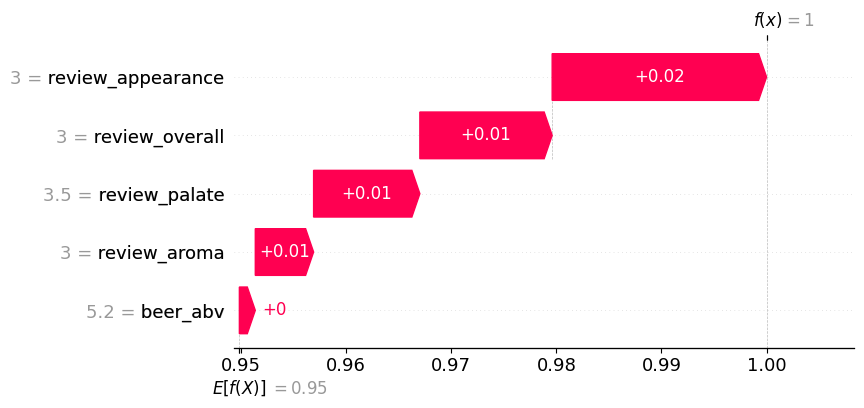

##############################################################################


##############################################################################
beer_beerid                                 76296
beer_name              Continuum Series Brown Ale
brewery_id                                   1497
brewery_name                              Jupiter
beer_style                     American Brown Ale
beer_abv                                      4.5
review_overall                                4.0
review_aroma                                  4.0
review_appearance                             4.0
review_palate                                 4.0
review_taste                                  4.0
cantidad_revisiones                             1
revision_primera                       2011-12-13
revision_ultima                        2011-12-13
es_popular                                     NO
Name: 5225, dtype: object
################################################################

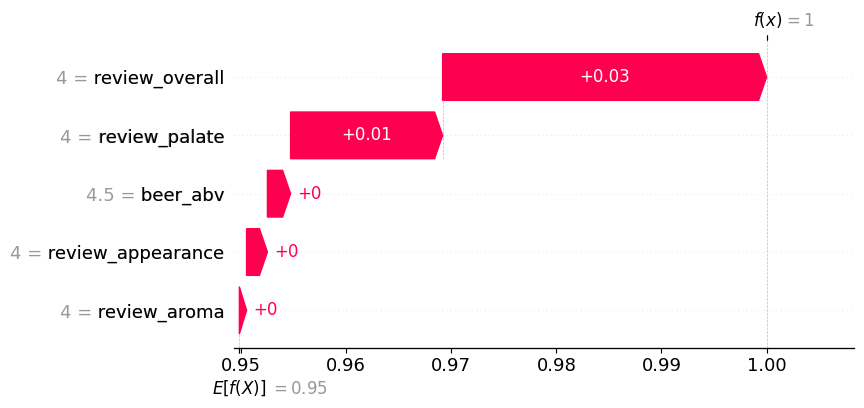

##############################################################################


##############################################################################
beer_beerid                            9029
beer_name                    Truby Dog Bock
brewery_id                             1636
brewery_name           Bethlehem Brew Works
beer_style                             Bock
beer_abv                                6.4
review_overall                          3.5
review_aroma                            4.0
review_appearance                       4.0
review_palate                           3.5
review_taste                            4.0
cantidad_revisiones                       1
revision_primera                 2003-03-22
revision_ultima                  2003-03-22
es_popular                               NO
Name: 4791, dtype: object
##############################################################################
shap_beer_abv            -0.002443
shap_review_aroma        -0.001343
shap_

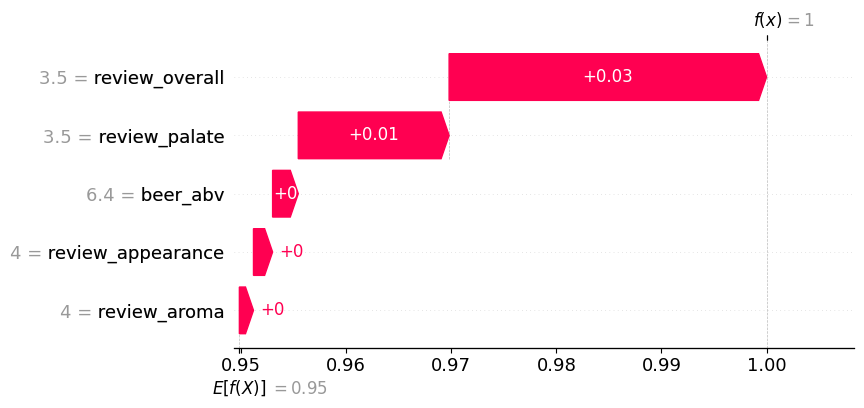

##############################################################################


##############################################################################
beer_beerid                              14618
beer_name                Ho Ho Ho Magic Dubbel
brewery_id                                1837
brewery_name           Buckeye Brewing Company
beer_style                              Dubbel
beer_abv                                   7.5
review_overall                        3.446429
review_aroma                          3.535714
review_appearance                     3.696429
review_palate                         3.482143
review_taste                          3.410714
cantidad_revisiones                         28
revision_primera                    2004-01-09
revision_ultima                     2011-02-25
es_popular                                  NO
Name: 9991, dtype: object
##############################################################################
shap_beer_abv            -0.00

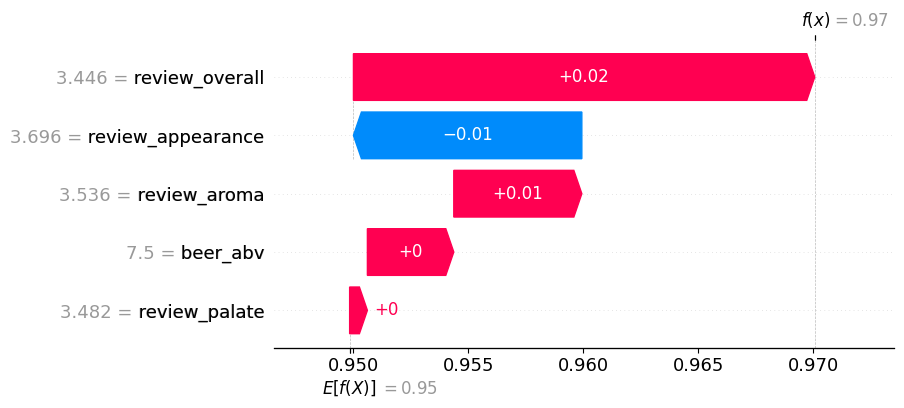

##############################################################################


##############################################################################
beer_beerid                              54044
beer_name                  Andechs Winter Bier
brewery_id                                 911
brewery_name           Klosterbrauerei Andechs
beer_style                                Bock
beer_abv                                   5.9
review_overall                             4.0
review_aroma                               4.0
review_appearance                          4.0
review_palate                              4.0
review_taste                               4.0
cantidad_revisiones                          1
revision_primera                    2009-11-11
revision_ultima                     2009-11-11
es_popular                                  NO
Name: 14695, dtype: object
##############################################################################
shap_beer_abv            -0.0

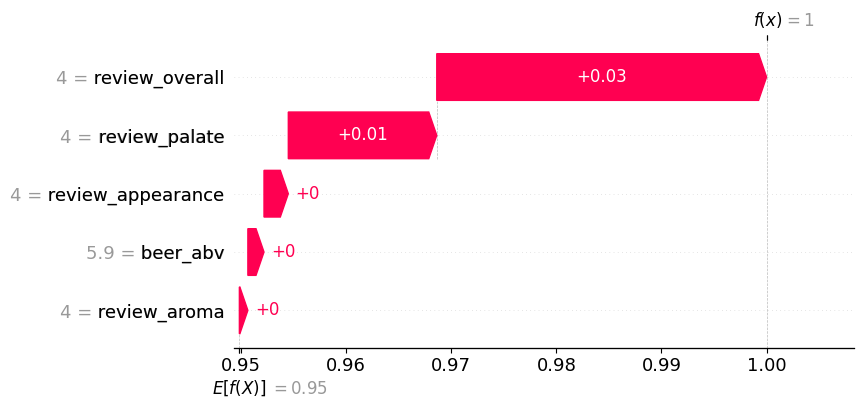

##############################################################################




In [46]:
rows = [826, 5225, 4791, 9991, 14695]
for row in rows:
    print('##############################################################################')
    print(df_info.iloc[row])
    print('##############################################################################')
    print(shap_df.iloc[row])
    explanation = shap.Explanation(
            values=shap_values[0][row], 
            base_values=explainer.expected_value[0], 
            data=X_testing.iloc[row],
            feature_names=atributos
    )

    shap.waterfall_plot(explanation)
    print('##############################################################################\n\n')

### Casos de cervezas populares

##############################################################################
beer_beerid                                       31547
beer_name                                  Black Magick
brewery_id                                        13371
brewery_name                     Voodoo Brewing Company
beer_style             American Double / Imperial Stout
beer_abv                                           15.0
review_overall                                 3.863636
review_aroma                                   4.230114
review_appearance                                4.0625
review_palate                                  3.965909
review_taste                                   4.130682
cantidad_revisiones                                 176
revision_primera                             2008-10-05
revision_ultima                              2012-01-05
es_popular                                           SI
Name: 14654, dtype: object
######################################################

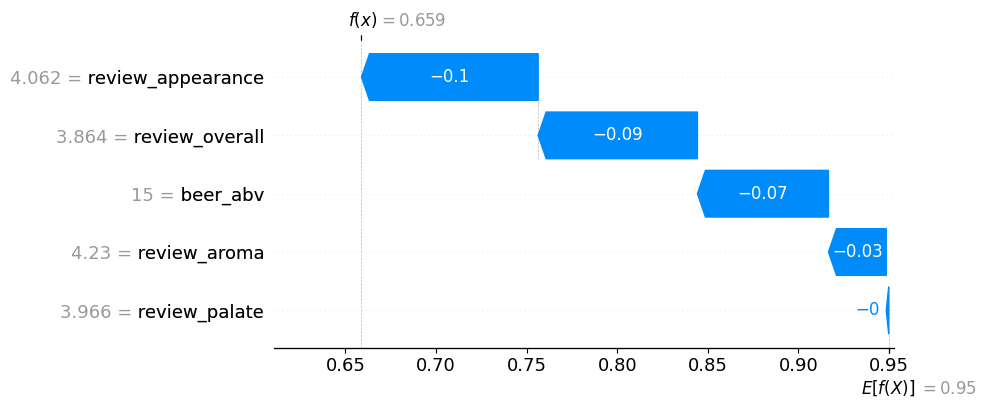

##############################################################################


##############################################################################
beer_beerid                                 37142
beer_name                      Coney Island Lager
brewery_id                                    262
brewery_name              Shmaltz Brewing Company
beer_style             American Amber / Red Lager
beer_abv                                      5.5
review_overall                           3.803493
review_aroma                             3.567686
review_appearance                        3.838428
review_palate                            3.746725
review_taste                             3.733624
cantidad_revisiones                           229
revision_primera                       2007-06-18
revision_ultima                        2012-01-06
es_popular                                     SI
Name: 9923, dtype: object
################################################################

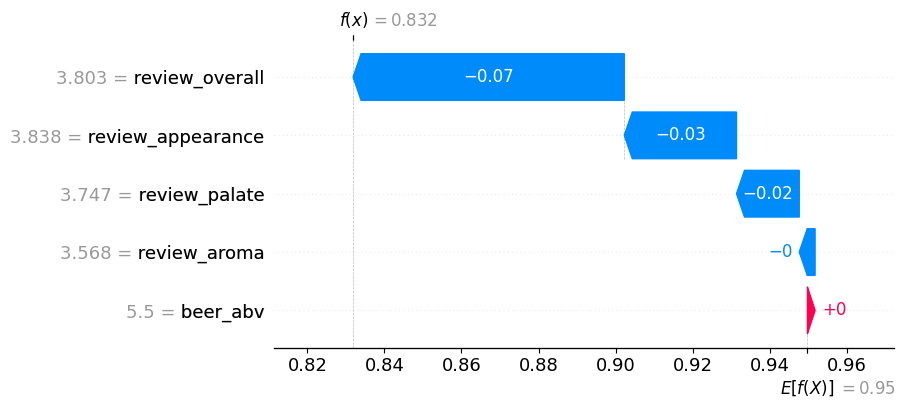

##############################################################################


##############################################################################
beer_beerid                               54827
beer_name                Founders Black Biscuit
brewery_id                                 1199
brewery_name           Founders Brewing Company
beer_style                              Old Ale
beer_abv                                   10.5
review_overall                         4.271812
review_aroma                           4.258389
review_appearance                      4.167785
review_palate                          4.332215
review_taste                           4.493289
cantidad_revisiones                         149
revision_primera                     2009-12-18
revision_ultima                      2011-12-01
es_popular                                   SI
Name: 6916, dtype: object
##############################################################################
shap_beer_abv  

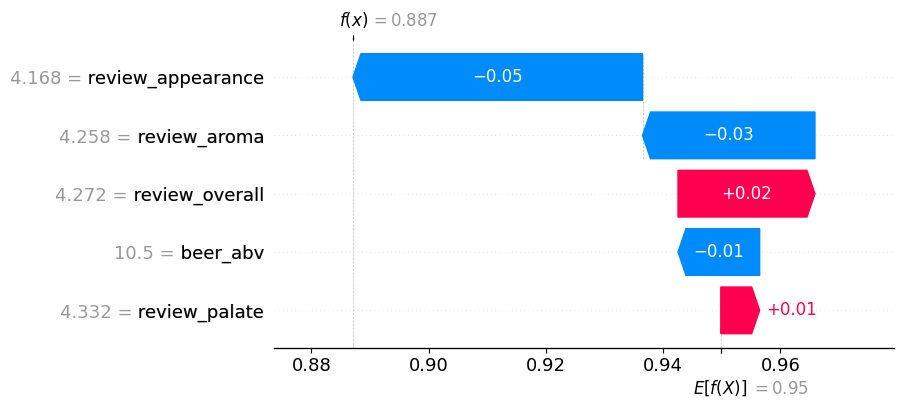

##############################################################################


##############################################################################
beer_beerid                                            31484
beer_name              AleSmith Speedway Stout - Barrel Aged
brewery_id                                               396
brewery_name                        AleSmith Brewing Company
beer_style                  American Double / Imperial Stout
beer_abv                                                12.0
review_overall                                      4.352941
review_aroma                                        4.497549
review_appearance                                   4.323529
review_palate                                       4.379902
review_taste                                        4.482843
cantidad_revisiones                                      204
revision_primera                                  2003-12-27
revision_ultima                                

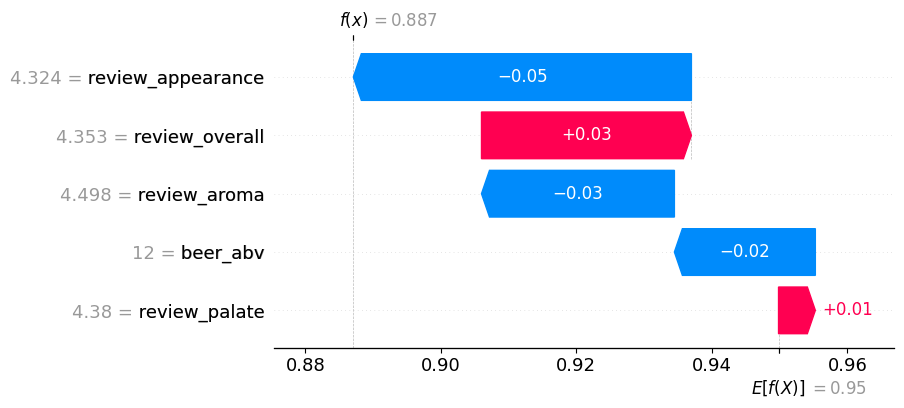

##############################################################################


##############################################################################
beer_beerid                                   2566
beer_name                    Maredsous 10 - Triple
brewery_id                                     222
brewery_name           Brouwerij Duvel Moortgat NV
beer_style                                  Tripel
beer_abv                                      10.0
review_overall                            3.830343
review_aroma                              3.872757
review_appearance                         4.114192
review_palate                             3.880098
review_taste                              3.868679
cantidad_revisiones                            613
revision_primera                        2002-03-31
revision_ultima                         2012-01-11
es_popular                                      SI
Name: 366, dtype: object
##################################################

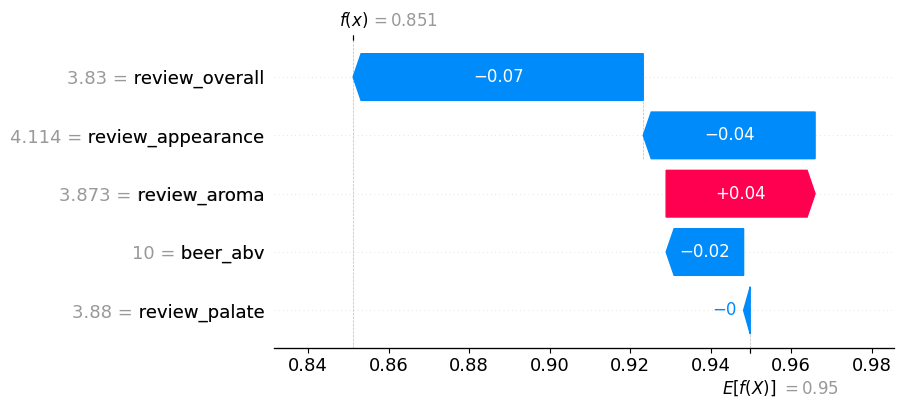

##############################################################################




In [47]:
rows = [14654, 9923, 6916, 4882, 366]
for row in rows:
    print('##############################################################################')
    print(df_info.iloc[row])
    print('##############################################################################')
    print(shap_df.iloc[row])
    explanation = shap.Explanation(
            values=shap_values[0][row], 
            base_values=explainer.expected_value[0], 
            data=X_testing.iloc[row],
            feature_names=atributos
    )

    shap.waterfall_plot(explanation)
    print('##############################################################################\n\n')